# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative = False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative = False):
    if derivative:
        return - (y - y_pred) / y_pred.shape[0]
    return 0.5 * np.mean((y - y_pred) ** 2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative = False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y_pred.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1 - y_pred) )

def sigmoid_cross_entropy(y, y_pred, derivative = False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y_pred.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1 - y_sigmoid) )

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)
    
def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    std_dev = np.sqrt(6 / (rows + cols))
    return 2 * std_dev * np.random.randn(rows, cols) - std_dev

# Regularização

In [8]:
def l1_regularization(weights, derivative = False):
    if derivative:
        weights = [np.where(w < 0, -1 , w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative = False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights ** 2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size = None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:(offset + batch_size)], y[offset:(offset + batch_size)]
        yield (x_batch, y_batch)

def batch_shuffle(x, y, batch_size = None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_steps = 1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps = 1):
    return 1 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps = 1):
    return learning_rate * decay_rate ** epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps = 1):
    return learning_rate * decay_rate ** (epoch // decay_steps)

# Batch Normalization 

In [11]:
def batchnorm_forward(layer, x, is_training = True):
    mu = np.mean(x, axis = 0) if is_training else layer._pop_mean
    var = np.var(x, axis = 0) if is_training else layer._pop_var
    x_norm = (x - mu)/np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta
    
    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0 - layer.bn_decay) * mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0 - layer.bn_decay) * var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache
    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8)
    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis = 0) * -0.5*(std_inv ** 3)
    dmu = np.sum((dx_norm * -std_inv), axis = 0) + dvar * np.mean((-2.0 * x_mu), axis = 0)
    dx = (dx_norm * std_inv) + ((dvar * 2 * x_mu) / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis = 0)
    layer._dbeta = np.sum(dactivation, axis = 0)
    
    return dx
    
    

# Implementação 

In [12]:
class Layer():
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 weights_initializer = random_normal,
                 biases_initializer = ones,
                 activation = linear, 
                 dropout_prob = 0,
                 reg_func = l2_regularization,
                 reg_strength = 0, 
                 batch_norm = False, 
                 bn_decay = 0.9, 
                 is_trainable = True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)
        self.is_trainable = is_trainable
        
        self._activ_inp, self._active_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None


class NeuralNetwork():
    def __init__(self, 
                 cost_func = mse, 
                 learning_rate = 1e-3, 
                 lr_decay_method = none_decay,
                 lr_decay_rate = 0.0,
                 lr_decay_steps = 1,
                 momentum = 0.0, 
                 patience = np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val = None, y_val = None, epochs = 100, verbose=10, batch_gen = batch_sequential, batch_size = None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        for epoch in range(epochs + 1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)
            
            loss_val = self.cost_func(y_val, self.predict(x_val))
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0 / y_train.shape[0]) * np.sum([(layer.reg_strength * layer.reg_func(layer.weights)) for layer in self.layers])
                print("epoch: {0:-4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, loss_train, loss_reg, loss_train + loss_reg, loss_val))
        
    def predict(self, x):
        return self.__feedforward(x, is_training = False)

    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)
    
    def load(file_path):
        return pkl.load(open(file_path, 'rb'))
    
    def __feedforward(self, x, is_training = True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0 - current_layer.dropout_prob, y.shape) / (1.0 - current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._active_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._active_out
        return self.layers[-1]._active_out
            
        
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative = True)

        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative = True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis = 0, keepdims = True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0 / y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative = True)
                layer._prev_dweights = -self.learning_rate * layer._dweights + self.momentum * layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate * layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                    layer.beta = layer.beta - self.learning_rate * layer._dbeta

In [13]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples = 100, n_features = 1, n_informative = 2, noise = 10.0, random_state = 42)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-1, patience = 10)

nn.layers.append(Layer(input_dim = x.shape[1], output_dim = y.shape[1], activation = linear))
nn.fit(x_train, y_train, x_val = x_test, y_val = y_test, epochs = 1000, verbose = 50)

epoch:    0/1000 loss_train: 683.72289510 + 0.00000000 = 683.72289510 loss_val = 719.65225362
epoch:   50/1000 loss_train: 35.44315167 + 0.00000000 = 35.44315167 loss_val = 53.32344591
epoch:  100/1000 loss_train: 35.23224445 + 0.00000000 = 35.23224445 loss_val = 51.77107720
epoch:  150/1000 loss_train: 35.23214680 + 0.00000000 = 35.23214680 loss_val = 51.73727715
epoch:  200/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73653000
epoch:  250/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651378
epoch:  300/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  350/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  400/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  450/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342


## Exemplos do Notebook da Intuição

### Exemplo 1

In [14]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!
input_dim, output_dim = x.shape[0], y.shape[0]
nn = NeuralNetwork(cost_func = mse, learning_rate = 0.5)
nn.layers.append(Layer(input_dim = input_dim, output_dim = 2, activation = sigmoid))
nn.layers.append(Layer(input_dim = 2, output_dim = output_dim, activation = sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1

nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs = 0, verbose = 1)
for layer in nn.layers:
    print(layer.weights)
    
print('Trainable == False')

for layer in nn.layers[:-1]:
    layer.is_trainable = False

nn.fit(x, y, epochs = 1000, verbose = 100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val = 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]
Trainable == False
epoch:    0/1000 loss_train: 0.13098517 + 0.00000000 = 0.13098517 loss_val = 0.13098517
epoch:  100/1000 loss_train: 0.00326789 + 0.00000000 = 0.00326789 loss_val = 0.00326789
epoch:  200/1000 loss_train: 0.00142285 + 0.00000000 = 0.00142285 loss_val = 0.00142285
epoch:  300/1000 loss_train: 0.00086728 + 0.00000000 = 0.00086728 loss_val = 0.00086728
epoch:  400/1000 loss_train: 0.00060653 + 0.00000000 = 0.00060653 loss_val = 0.00060653
epoch:  500/1000 loss_train: 0.00045743 + 0.00000000 = 0.00045743 loss_val = 0.00045743
epoch:  600/1000 loss_train: 0.00036192 + 0.00000000 = 0.00036192 loss_val = 0.00036192
epoch:  700/1000 loss_train: 0.00029601 + 0.00000000 = 0.00029601 loss_val = 0.00029601
epoch:  800/1000 loss_train: 0.00024808 + 0.00000000 = 0.00024808 loss_val = 0.00024808
ep

### Exemplo 2

In [15]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 0.01)
nn.layers.append(Layer(input_dim = D_in, output_dim = 3, activation = relu))
nn.layers.append(Layer(input_dim = 3, output_dim = 3, activation = sigmoid))
nn.layers.append(Layer(input_dim = 3, output_dim = D_out, activation = linear))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b
    
nn.fit(x, y, epochs = 300, verbose = 30)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val = 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val = 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val = 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val = 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val = 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val = 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val = 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val = 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val = 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val = 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val = 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.300

## Gradient Checking

In [75]:
def compute_approx_grade(nn, x, y, eps = 1e-4):
    approx_grads = []
    feed_forward = lambda inp: nn._NeuralNetwork__feedforward(inp, is_training = True)
    
    for layer in nn.layers:
        assert(layer.dropout_prob == 0), "O Gradient Checking nao pode ser aplicado em redes com dropout"
        w_ori = layer.weights.copy()
        w_ravel = w_ori.ravel()
        w_shape = w_ori.shape
        
        for i in range(w_ravel.size):
            w_plus = w_ravel.copy()
            w_plus[i] = eps + w_plus[i]
            layer.weights = w_plus.reshape(w_shape)
            J_plus = nn.cost_func(y, feed_forward(x)) + (1.0 / y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights)
            
            
            w_minus = w_ravel.copy()
            w_minus[i] -= eps
            layer.weights = w_minus.reshape(w_shape)
            J_minus = nn.cost_func(y, feed_forward(x)) + (1.0 / y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights)
            
            approx_grads.append((J_plus - J_minus) / (2*eps))
        layer.weights = w_ori
    return approx_grads

def gradient_checking(nn, x, y, eps = 1e-4, verbose = False, verbose_precision=5):
    from copy import deepcopy
    nn_copy = deepcopy(nn)
    
    nn.fit(x, y, epochs = 0)
    grads = np.concatenate([layer._dweights.ravel() for layer in nn.layers])
    
    approx_grads = compute_approx_grade(nn_copy, x, y, eps)
    
    is_close = np.allclose(grads, approx_grads)
    print("{}".format("\033[92mGRADIENTS OK" if is_close else "\033[91mGRADIENTS FAIL"))
    
    norm_num = np.linalg.norm(grads - approx_grads)
    norm_den = np.linalg.norm(grads) + np.linalg.norm(approx_grads)
    
    error = norm_num / norm_den
    print("Relative error: ", error)

    if verbose:
        np.set_printoptions(precision = verbose_precision, linewidth = 200, suppress = True)
        print("Gradients: ", grads)
        print("Aproximados: ", np.array(approx_grads))


In [76]:
np.random.seed(1234)

N, D = 100, 2
x = np.random.rand(N, D)

In [77]:
y = np.random.rand(N, 1)
nn = NeuralNetwork(cost_func = mse, 
                   learning_rate = 1e-3, 
                   momentum = 0.9, 
                   lr_decay_method = staircase_decay, 
                   lr_decay_rate = 0.5,
                   lr_decay_steps = 10)

nn.layers.append(Layer(input_dim = x.shape[1], output_dim = 4, activation = relu, batch_norm = True))
nn.layers.append(Layer(input_dim = 4, output_dim = 1, activation = tanh))
nn.layers.append(Layer(input_dim = 1, output_dim = 2, activation = sigmoid, batch_norm = True))
nn.layers.append(Layer(input_dim = 2, output_dim = 5, activation = leaky_relu))
nn.layers.append(Layer(input_dim = 5, output_dim = 3, activation = elu, batch_norm = True))
nn.layers.append(Layer(input_dim = 3, output_dim = y.shape[1], activation = linear, batch_norm = True))

nn.fit(x, y, epochs = 100)
gradient_checking(nn, x, y, eps = 1e-4, verbose = True)

epoch:    0/100 loss_train: 88.38710432 + 0.00000000 = 88.38710432 loss_val = 88.38710432
epoch:   10/100 loss_train: 2.32652896 + 0.00000000 = 2.32652896 loss_val = 2.32652896
epoch:   20/100 loss_train: 1.09015698 + 0.00000000 = 1.09015698 loss_val = 1.09015698
epoch:   30/100 loss_train: 0.78893075 + 0.00000000 = 0.78893075 loss_val = 0.78893075
epoch:   40/100 loss_train: 0.68924965 + 0.00000000 = 0.68924965 loss_val = 0.68924965
epoch:   50/100 loss_train: 0.65392218 + 0.00000000 = 0.65392218 loss_val = 0.65392218
epoch:   60/100 loss_train: 0.64134872 + 0.00000000 = 0.64134872 loss_val = 0.64134872
epoch:   70/100 loss_train: 0.63681285 + 0.00000000 = 0.63681285 loss_val = 0.63681285
epoch:   80/100 loss_train: 0.63514985 + 0.00000000 = 0.63514985 loss_val = 0.63514985
epoch:   90/100 loss_train: 0.63452768 + 0.00000000 = 0.63452768 loss_val = 0.63452768
epoch:  100/100 loss_train: 0.63428912 + 0.00000000 = 0.63428912 loss_val = 0.63428912
epoch:    0/0 loss_train: 0.63313464 + 0

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


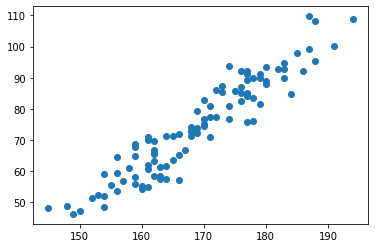

In [65]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


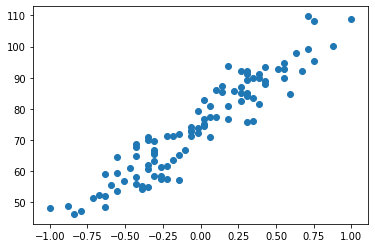

In [66]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000 loss_train: 2749.85675458
epoch:  100/1000 loss_train: 443.28237886
epoch:  200/1000 loss_train: 114.61741313
epoch:  300/1000 loss_train: 56.89821424
epoch:  400/1000 loss_train: 39.72745076
epoch:  500/1000 loss_train: 30.93188851
epoch:  600/1000 loss_train: 25.28531683
epoch:  700/1000 loss_train: 21.45524717
epoch:  800/1000 loss_train: 18.82790124
epoch:  900/1000 loss_train: 17.02160652
epoch: 1000/1000 loss_train: 15.77924707
[[28.19093091]]
[[74.85473183]]


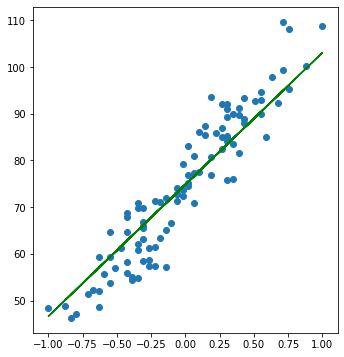

In [67]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-2)
nn.layers.append(Layer(input_dim = input_dim, output_dim = output_dim, activation = linear))
    
nn.fit(x, y, epochs = 1000, verbose = 100)
print(nn.layers[0].weights)
print(nn.layers[0].biases)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [30]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [31]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [37]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim = input_dim, output_dim = output_dim, activation = linear))
nn.fit(x, y, epochs = 2000, verbose = 200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 1006.94948999
epoch:  200/2000 loss_train: 489.56655892
epoch:  400/2000 loss_train: 489.56654159
epoch:  600/2000 loss_train: 489.56654159
epoch:  800/2000 loss_train: 489.56654159
epoch: 1000/2000 loss_train: 489.56654159
epoch: 1200/2000 loss_train: 489.56654159
epoch: 1400/2000 loss_train: 489.56654159
epoch: 1600/2000 loss_train: 489.56654159
epoch: 1800/2000 loss_train: 489.56654159
epoch: 2000/2000 loss_train: 489.56654159
[[10.14188685]]
[[35.68455232]]


### Regressão Quadrática

(100, 1) (100, 1)


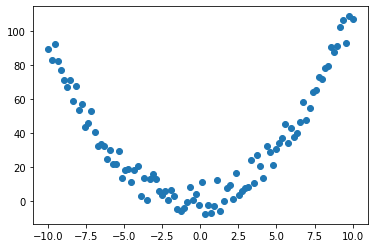

In [25]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 1088.72414660
epoch:  100/1000 loss_train: 515.59143600
epoch:  200/1000 loss_train: 515.55642947
epoch:  300/1000 loss_train: 515.51280135
epoch:  400/1000 loss_train: 478.98892167
epoch:  500/1000 loss_train: 80.38677296
epoch:  600/1000 loss_train: 34.52809871
epoch:  700/1000 loss_train: 24.60011734
epoch:  800/1000 loss_train: 20.69423002
epoch:  900/1000 loss_train: 18.63442092
epoch: 1000/1000 loss_train: 17.40880003


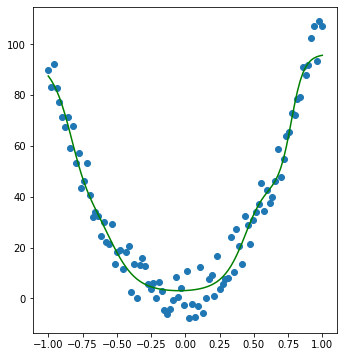

In [30]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3, momentum = 0.9)

# 1 camada
nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = tanh, weights_initializer = glorot_normal))
nn.layers.append(Layer(input_dim = 10, output_dim = 10, activation = tanh, weights_initializer = glorot_normal, biases_initializer = glorot_uniform))
# Ultima camada
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear, weights_initializer = glorot_normal))
nn.fit(x, y, epochs = 1000, verbose = 100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


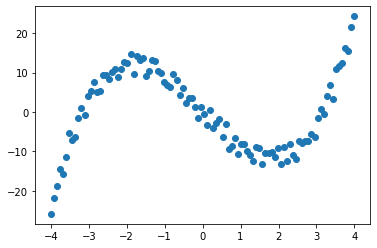

In [30]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [31]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 56.39284082
epoch:  500/5000 loss_train: 11.94334110
epoch: 1000/5000 loss_train: 9.54027535
epoch: 1500/5000 loss_train: 8.84265561
epoch: 2000/5000 loss_train: 6.96003577
epoch: 2500/5000 loss_train: 6.10764360
epoch: 3000/5000 loss_train: 5.70759622
epoch: 3500/5000 loss_train: 5.43010723
epoch: 4000/5000 loss_train: 5.05498476
epoch: 4500/5000 loss_train: 5.46490629
epoch: 5000/5000 loss_train: 5.42357195


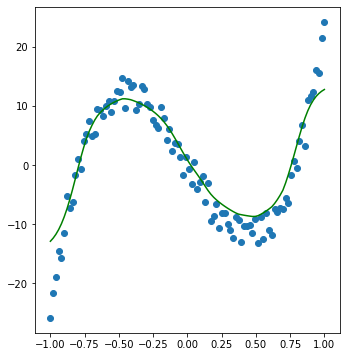

In [44]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)

# 1 camada
nn.layers.append(Layer(input_dim = input_dim, output_dim = 50, activation = relu))
nn.layers.append(Layer(input_dim = 50, output_dim = 50, activation = tanh, dropout_prob = 0.5))
# Ultima camada
nn.layers.append(Layer(input_dim = 50, output_dim = output_dim, activation = linear))

nn.fit(x, y, epochs = 5000, verbose = 500)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


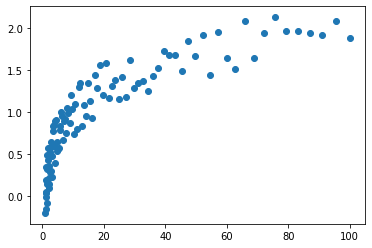

In [56]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [57]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 4.20534122
epoch:  500/5000 loss_train: 0.02443339
epoch: 1000/5000 loss_train: 0.02212103
epoch: 1500/5000 loss_train: 0.02095557
epoch: 2000/5000 loss_train: 0.02024450
epoch: 2500/5000 loss_train: 0.01976211
epoch: 3000/5000 loss_train: 0.01940812
epoch: 3500/5000 loss_train: 0.01913131
epoch: 4000/5000 loss_train: 0.01890343
epoch: 4500/5000 loss_train: 0.01870815
epoch: 5000/5000 loss_train: 0.01853576


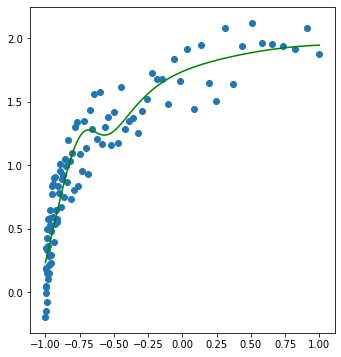

In [59]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-2)

# 1 camada
nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = tanh))
nn.layers.append(Layer(input_dim = 10, output_dim = 10, activation = tanh))
# Ultima camada
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear))
nn.fit(x, y, epochs = 5000, verbose = 500)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


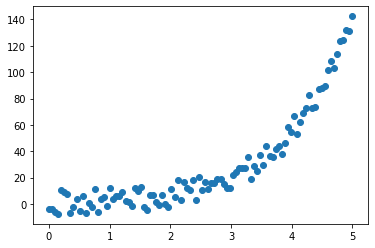

In [60]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [61]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 1060.84770535
epoch:  500/5000 loss_train: 20.94270781
epoch: 1000/5000 loss_train: 17.11833790
epoch: 1500/5000 loss_train: 15.70900014
epoch: 2000/5000 loss_train: 15.26664370
epoch: 2500/5000 loss_train: 14.99190941
epoch: 3000/5000 loss_train: 14.80047616
epoch: 3500/5000 loss_train: 14.65498549
epoch: 4000/5000 loss_train: 14.53899678
epoch: 4500/5000 loss_train: 14.30156494
epoch: 5000/5000 loss_train: 14.34553169


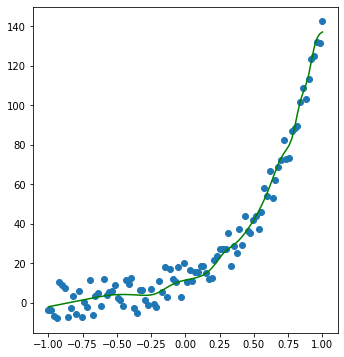

In [62]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-2)

# 1 camada
nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = tanh))
nn.layers.append(Layer(input_dim = 10, output_dim = 10, activation = tanh))
# Ultima camada
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear))
nn.fit(x, y, epochs = 5000, verbose = 500)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


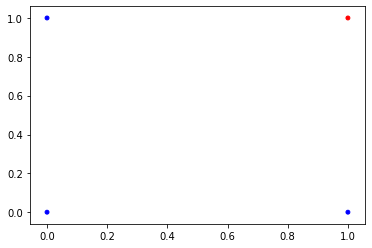

In [99]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.75222479
epoch:  100/1000 loss_train: 0.14173861
epoch:  200/1000 loss_train: 0.08096830
epoch:  300/1000 loss_train: 0.05618745
epoch:  400/1000 loss_train: 0.04283990
epoch:  500/1000 loss_train: 0.03454020
epoch:  600/1000 loss_train: 0.02889754
epoch:  700/1000 loss_train: 0.02481977
epoch:  800/1000 loss_train: 0.02173898
epoch:  900/1000 loss_train: 0.01933141
epoch: 1000/1000 loss_train: 0.01739929
Predições:
[[1.24136285e-05]
 [2.02204021e-02]
 [2.02203798e-02]
 [9.71679249e-01]]
Acurácia: 100.00%


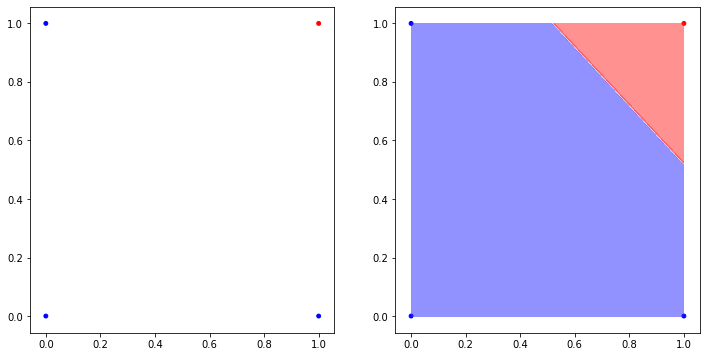

In [100]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1.0)
nn.layers.append(Layer(input_dim = input_dim, output_dim = output_dim, activation = sigmoid))

nn.fit(x, y, epochs = 1000, verbose = 100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


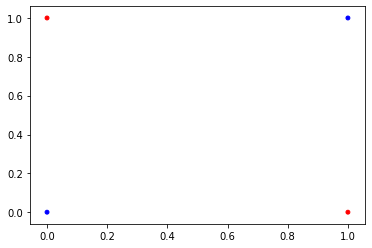

In [101]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss_train: 0.76593635
epoch:  200/2000 loss_train: 0.67580650
epoch:  400/2000 loss_train: 0.52143678
epoch:  600/2000 loss_train: 0.09804048
epoch:  800/2000 loss_train: 0.03418550
epoch: 1000/2000 loss_train: 0.02027028
epoch: 1200/2000 loss_train: 0.01431724
epoch: 1400/2000 loss_train: 0.01103657
epoch: 1600/2000 loss_train: 0.00896577
epoch: 1800/2000 loss_train: 0.00754251
epoch: 2000/2000 loss_train: 0.00650538
Predições:
[[0.00757281]
 [0.99405098]
 [0.99427701]
 [0.00669119]]
Acurácia: 100.00%


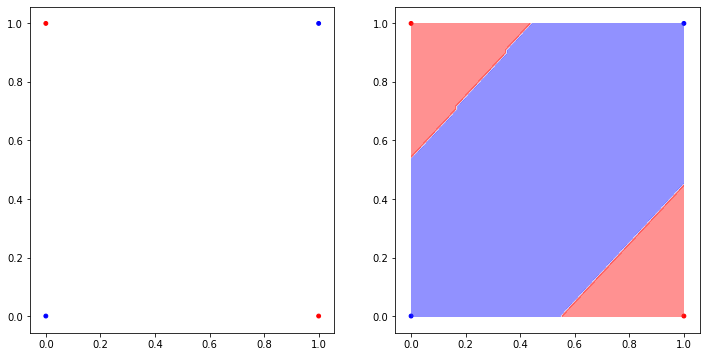

In [105]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1.0)
nn.layers.append(Layer(input_dim = input_dim, output_dim = 2, activation = sigmoid))
nn.layers.append(Layer(input_dim = 2, output_dim = output_dim, activation = sigmoid))


nn.fit(x, y, epochs = 2000, verbose = 200)
y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


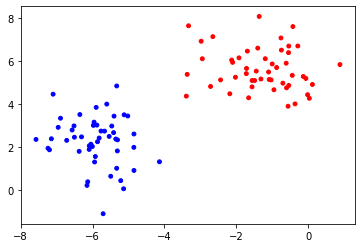

In [106]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 1.45645398
epoch: 1000/5000 loss_train: 0.18810007
epoch: 2000/5000 loss_train: 0.10194370
epoch: 3000/5000 loss_train: 0.07239149
epoch: 4000/5000 loss_train: 0.05727633
epoch: 5000/5000 loss_train: 0.04800626
Acurácia: 100.00%


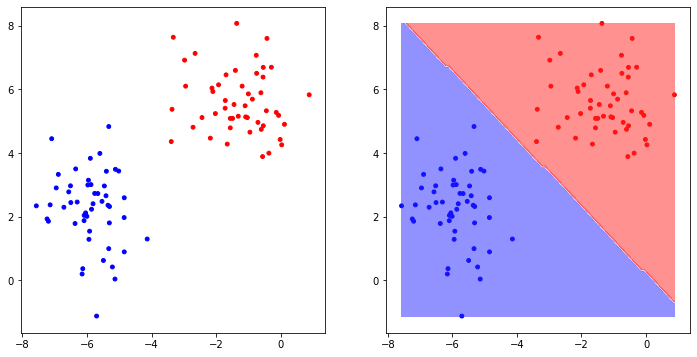

In [112]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-3)
nn.layers.append(Layer(input_dim = input_dim, output_dim = output_dim, activation = sigmoid))

nn.fit(x, y, epochs = 5000, verbose = 1000)
y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


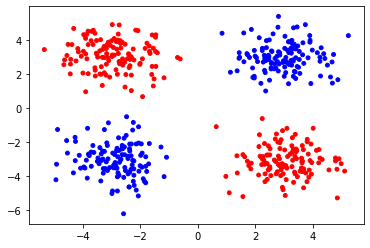

In [113]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 0.90095779
epoch:  200/5000 loss_train: 0.56427988
epoch:  400/5000 loss_train: 0.53989566
epoch:  600/5000 loss_train: 0.50200052
epoch:  800/5000 loss_train: 0.46630975
epoch: 1000/5000 loss_train: 0.44635626
epoch: 1200/5000 loss_train: 0.43352692
epoch: 1400/5000 loss_train: 0.42422559
epoch: 1600/5000 loss_train: 0.41704049
epoch: 1800/5000 loss_train: 0.41124530
epoch: 2000/5000 loss_train: 0.40632795
epoch: 2200/5000 loss_train: 0.40157892
epoch: 2400/5000 loss_train: 0.39130294
epoch: 2600/5000 loss_train: 0.29730415
epoch: 2800/5000 loss_train: 0.20891074
epoch: 3000/5000 loss_train: 0.16110483
epoch: 3200/5000 loss_train: 0.13415254
epoch: 3400/5000 loss_train: 0.11680450
epoch: 3600/5000 loss_train: 0.10480866
epoch: 3800/5000 loss_train: 0.09605453
epoch: 4000/5000 loss_train: 0.08939588
epoch: 4200/5000 loss_train: 0.08416514
epoch: 4400/5000 loss_train: 0.07994996
epoch: 4600/5000 loss_train: 0.07648275
epoch: 4800/5000 loss_train: 0.07358251


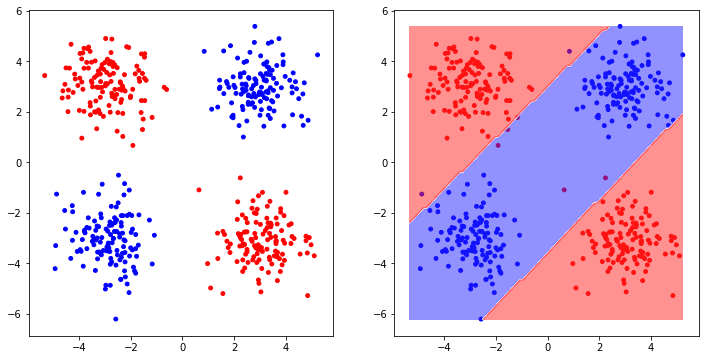

In [117]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim = input_dim, output_dim = 2, activation = sigmoid))
nn.layers.append(Layer(input_dim = 2, output_dim = output_dim, activation = sigmoid))


nn.fit(x, y, epochs = 5000, verbose = 200)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


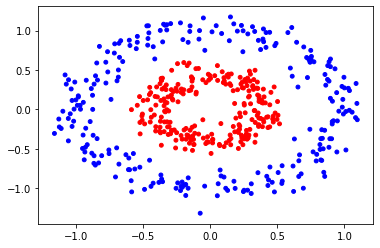

In [125]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 0.74220762
epoch: 1000/5000 loss_train: 0.61713351
epoch: 2000/5000 loss_train: 0.43837390
epoch: 3000/5000 loss_train: 0.24232021
epoch: 4000/5000 loss_train: 0.15173606
epoch: 5000/5000 loss_train: 0.11092873
Acurácia: 99.60%


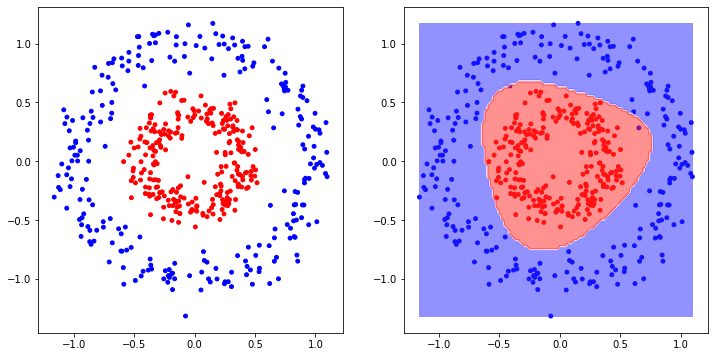

In [132]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim = input_dim, output_dim = 8, activation = sigmoid))
nn.layers.append(Layer(input_dim = 8, output_dim = output_dim, activation = sigmoid))

nn.fit(x, y, epochs = 5000, verbose = 1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


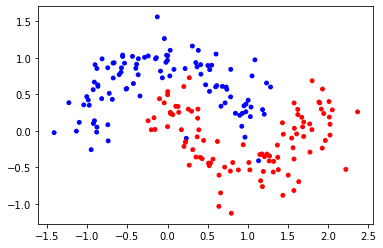

In [98]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 0.91023209 + 0.01922918 = 0.92946127 loss_val = 0.91023209
epoch: 1000/5000 loss_train: 0.33489987 + 0.04179092 = 0.37669079 loss_val = 0.33489987
epoch: 2000/5000 loss_train: 0.32784167 + 0.04316007 = 0.37100173 loss_val = 0.32784167
epoch: 3000/5000 loss_train: 0.32682725 + 0.04246431 = 0.36929155 loss_val = 0.32682725
epoch: 4000/5000 loss_train: 0.32651917 + 0.04185954 = 0.36837872 loss_val = 0.32651917
epoch: 5000/5000 loss_train: 0.32635556 + 0.04143070 = 0.36778626 loss_val = 0.32635556
Acurácia: 83.50%


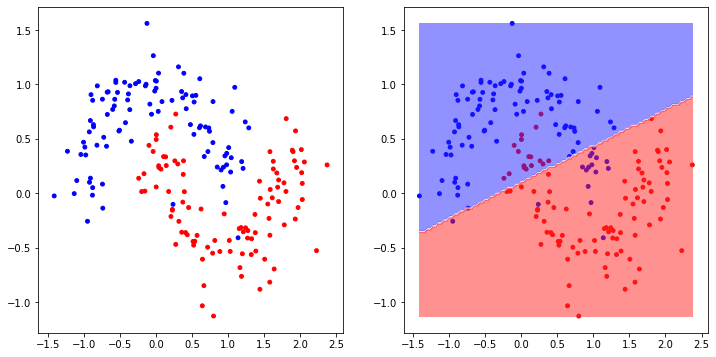

In [99]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = sigmoid, reg_func = l2_regularization, reg_strength = 0.5))
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = sigmoid, reg_func = l2_regularization, reg_strength = 0.5))

nn.fit(x, y, epochs = 5000, verbose = 1000)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


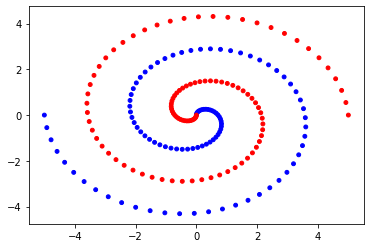

In [117]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 1.86573323 + 0.00000000 = 1.86573323 loss_val = 1.86573323
epoch: 1000/5000 loss_train: 0.66218595 + 0.00000000 = 0.66218595 loss_val = 0.66218595
epoch: 2000/5000 loss_train: 0.19515090 + 0.00000000 = 0.19515090 loss_val = 0.19515090
epoch: 3000/5000 loss_train: 0.01906733 + 0.00000000 = 0.01906733 loss_val = 0.01906733
epoch: 4000/5000 loss_train: 0.01329352 + 0.00000000 = 0.01329352 loss_val = 0.01329352
epoch: 5000/5000 loss_train: 0.01128194 + 0.00000000 = 0.01128194 loss_val = 0.01128194
Acurácia: 99.50%


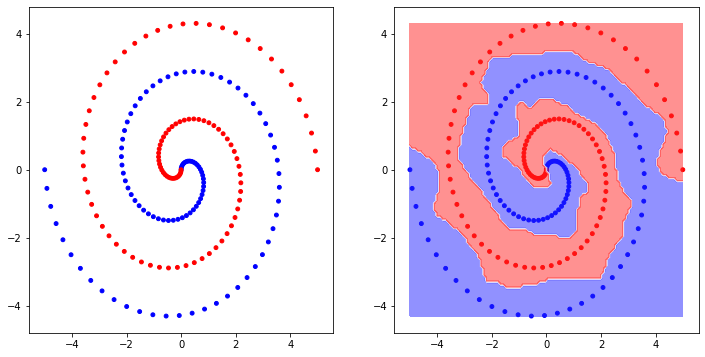

In [118]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim = input_dim, output_dim = 20, activation = tanh))
nn.layers.append(Layer(input_dim = 20, output_dim = 20, activation = tanh, batch_norm = True))
nn.layers.append(Layer(input_dim = 20, output_dim = output_dim, activation = sigmoid, batch_norm = True))

nn.fit(x, y, epochs = 5000, verbose = 1000)


y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


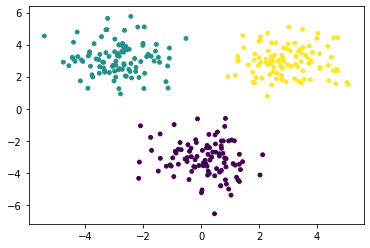

In [58]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [59]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 5.70099423
epoch:  100/1000 loss_train: 0.14971063
epoch:  200/1000 loss_train: 0.06437337
epoch:  300/1000 loss_train: 0.03951675
epoch:  400/1000 loss_train: 0.02813762
epoch:  500/1000 loss_train: 0.02172277
epoch:  600/1000 loss_train: 0.01763960
epoch:  700/1000 loss_train: 0.01482969
epoch:  800/1000 loss_train: 0.01277915
epoch:  900/1000 loss_train: 0.01121903
epoch: 1000/1000 loss_train: 0.00999333
Acurácia: 100.00%


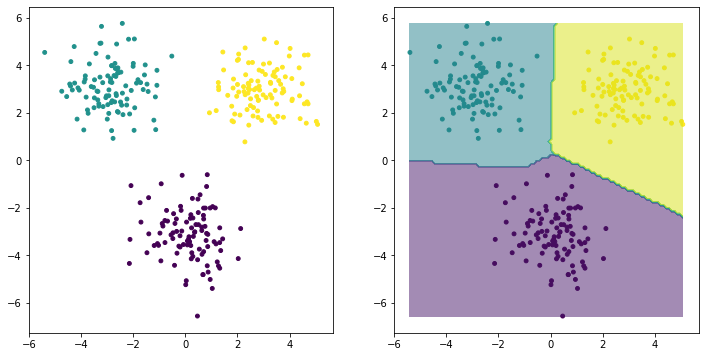

In [60]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)

nn.layers.append(Layer(input_dim = input_dim, output_dim = 2, activation = relu))
nn.layers.append(Layer(input_dim = 2, output_dim = output_dim, activation = linear))

nn.fit(x, y_onehot, epochs = 1000, verbose = 100)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


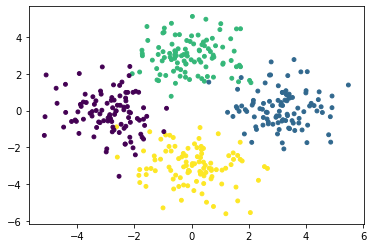

In [172]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [173]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 2.67540499
epoch:  100/1000 loss_train: 0.09908621
epoch:  200/1000 loss_train: 0.08449078
epoch:  300/1000 loss_train: 0.07933361
epoch:  400/1000 loss_train: 0.07631323
epoch:  500/1000 loss_train: 0.07444571
epoch:  600/1000 loss_train: 0.07326160
epoch:  700/1000 loss_train: 0.07228727
epoch:  800/1000 loss_train: 0.07146695
epoch:  900/1000 loss_train: 0.07086857
epoch: 1000/1000 loss_train: 0.07035215
Acurácia: 97.00%


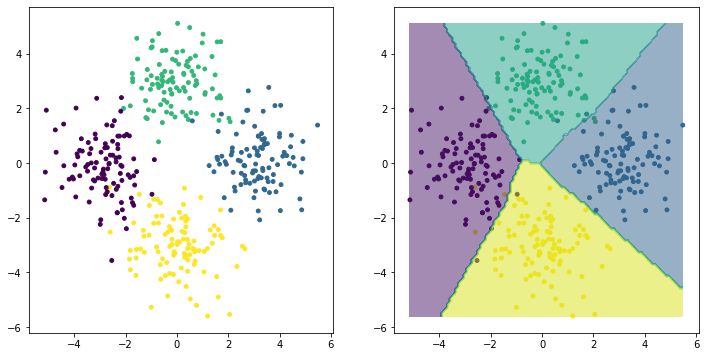

In [176]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)

nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = relu))
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear))

nn.fit(x, y_onehot, epochs = 1000, verbose = 100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


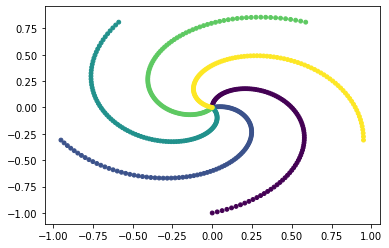

In [177]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [178]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 2.40680197
epoch:  100/1000 loss_train: 0.95687865
epoch:  200/1000 loss_train: 0.79399897
epoch:  300/1000 loss_train: 0.68130238
epoch:  400/1000 loss_train: 0.59675949
epoch:  500/1000 loss_train: 0.52383833
epoch:  600/1000 loss_train: 0.43324799
epoch:  700/1000 loss_train: 0.33358469
epoch:  800/1000 loss_train: 0.27250802
epoch:  900/1000 loss_train: 0.23023796
epoch: 1000/1000 loss_train: 0.19842449
Acurácia: 97.20%


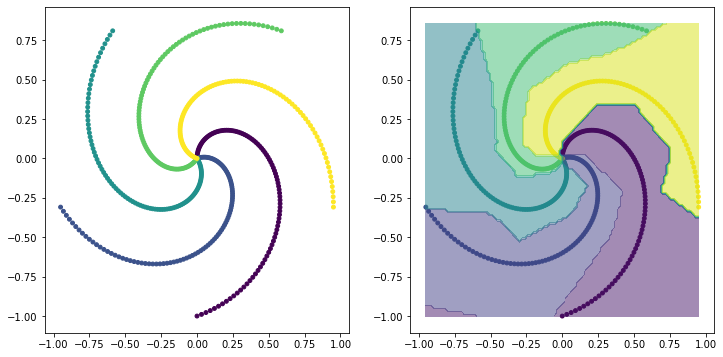

In [180]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)

nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = relu))
nn.layers.append(Layer(input_dim = 10, output_dim = 10, activation = relu))
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear))

nn.fit(x, y_onehot, epochs = 1000, verbose = 100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


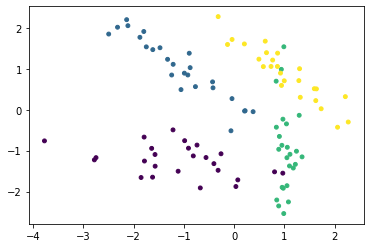

In [181]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [182]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 4.90259406
epoch:  100/1000 loss_train: 0.25288974
epoch:  200/1000 loss_train: 0.17702680
epoch:  300/1000 loss_train: 0.14187455
epoch:  400/1000 loss_train: 0.10244531
epoch:  500/1000 loss_train: 0.09456751
epoch:  600/1000 loss_train: 0.08851069
epoch:  700/1000 loss_train: 0.08447994
epoch:  800/1000 loss_train: 0.08200533
epoch:  900/1000 loss_train: 0.07962560
epoch: 1000/1000 loss_train: 0.07649180
Acurácia: 98.00%


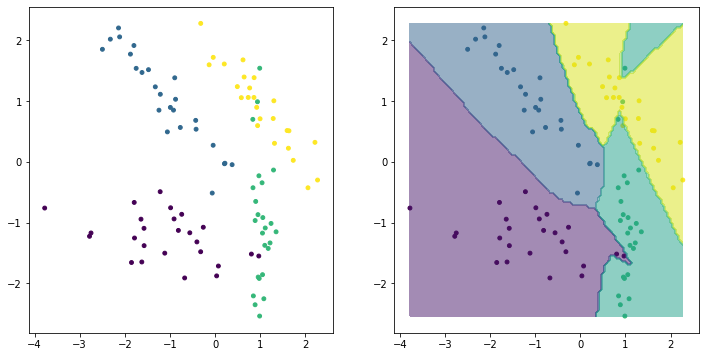

In [184]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)

nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = relu))
nn.layers.append(Layer(input_dim = 10, output_dim = 10, activation = relu))
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear))

nn.fit(x, y_onehot, epochs = 1000, verbose = 100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


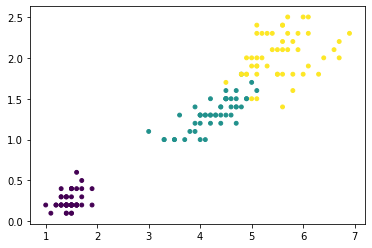

In [68]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [69]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [73]:
Layer?

Init signature:
Layer(
    input_dim,
    output_dim,
    weights_initializer=<function random_normal at 0x1a1ce369e0>,
    biases_initializer=<function ones at 0x1a1ce368c0>,
    activation=<function linear at 0x1a1cde3440>,
    dropout_prob=0,
    reg_func=<function l2_regularization at 0x1a1cde95f0>,
    reg_strength=0,
)
Docstring:      <no docstring>
Type:           type
Subclasses:     


epoch:    0/2000 loss_train: 0.40999775
epoch:  100/2000 loss_train: 0.10298273
epoch:  200/2000 loss_train: 0.08517508
epoch:  300/2000 loss_train: 0.08202039
epoch:  400/2000 loss_train: 0.08133718
epoch:  500/2000 loss_train: 0.08121503
epoch:  600/2000 loss_train: 0.08118483
epoch:  700/2000 loss_train: 0.08117729
epoch:  800/2000 loss_train: 0.08117541
epoch:  900/2000 loss_train: 0.08117494
epoch: 1000/2000 loss_train: 0.08117482
epoch: 1100/2000 loss_train: 0.08117479
epoch: 1200/2000 loss_train: 0.08117478
epoch: 1300/2000 loss_train: 0.08117478
epoch: 1400/2000 loss_train: 0.08117478
epoch: 1500/2000 loss_train: 0.08117478
epoch: 1600/2000 loss_train: 0.08117478
epoch: 1700/2000 loss_train: 0.08117478
epoch: 1800/2000 loss_train: 0.08117478
epoch: 1900/2000 loss_train: 0.08117478
epoch: 2000/2000 loss_train: 0.08117478
Acurácia: 95.33%


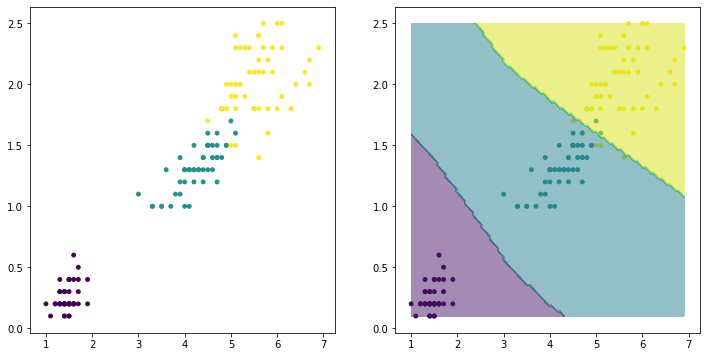

In [75]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, 
                   learning_rate = 1e-1, 
                   lr_decay_method = staircase_decay, 
                   lr_decay_rate = 0.5, 
                   lr_decay_steps = 50)

nn.layers.append(Layer(input_dim = input_dim, output_dim = 10, activation = relu, weights_initializer = glorot_normal))
nn.layers.append(Layer(input_dim = 10, output_dim = 10, activation = relu, weights_initializer = glorot_normal))
nn.layers.append(Layer(input_dim = 10, output_dim = output_dim, activation = linear))

nn.fit(x, y_onehot, epochs = 2000, verbose = 100, batch_gen = batch_shuffle, batch_size = 15)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)

 [Rede Neural.ipynb](../blob/master/"Rede Neural.ipynb")
